In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import numpy as np
import import_ipynb
import basefile as bf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder

importing Jupyter notebook from basefile.ipynb


In [2]:
class BaggingEnsembleClassifier: 
    def __init__(self, base_classifier, num_estimators, fraction_samples, bootstrap, voting):
        self.base_classifier = base_classifier
        self.num_estimators = num_estimators
        self.estimators = []
        self.sample_indices = []
        self.fraction_samples = fraction_samples
        self.bootstrap = bootstrap
        self.voting = voting
    def fit(self, X, y):        
        X_reset = X.reset_index(drop=True) if isinstance(X, pd.DataFrame) else X
        y_reset = y.reset_index(drop=True) if isinstance(y, pd.Series) else y
        for nums in range(self.num_estimators):
            if self.bootstrap:
                indices = resample(np.arange(len(X_reset)), n_samples=int(self.fraction_samples * len(X_reset)))
            else:
                indices = np.random.choice(np.arange(len(X_reset)), size=int(self.fraction_samples * len(X_reset)), replace=False)
            self.sample_indices.append(indices)
            X_sampled, y_sampled = X_reset[indices], y_reset[indices]
            base_model = None
            if self.base_classifier == "DT":
                base_model = DecisionTreeClassifier(max_depth=25, criterion="gini") 
            elif self.base_classifier == "LR":
                base_model = bf.MultinomialLogisticRegression(learning_rate = 0.1, max_iter = 2000)
            elif self.base_classifier == "MLP":
                base_model = bf.MLPClassifier(input_size=X.shape[1], hidden_layers=[10, 15], learning_rate=0.01, activation='tanh', epoch = 2000)
            base_model.fit(X_sampled, y_sampled)
            self.estimators.append(base_model)
    def predict(self, X):       
        if self.voting == 'HARD':
            if self.base_classifier == "MLP":
                estm = []
                for estimators in self.estimators:
                    estm.append(estimators.predict(X).flatten())
                y_pred = []
                for i in range(len(X)):
                    y_pred.append(np.argmax(np.bincount([est[i] for est in estm])))
                return np.array(y_pred)
            predictions = [estimator.predict(X) for estimator in self.estimators]
            predictions = np.array(predictions).T
            y_pred = np.array([np.argmax(np.bincount(class_prediction)) for class_prediction in predictions])
            return y_pred
        elif self.voting == 'SOFT' and self.base_classifier == "MLP":
            predictions = []
            confidences = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X).flatten())
                confidences.append(np.max(estimator.predict_proba(X), axis=1))
            predictions = np.array(predictions).T
            confidences = np.array(confidences).T
            y_pred = []
            for prediction, confidence in zip(predictions, confidences):
                class_weights = {}
                for pred, conf in zip(prediction, confidence):
                    pred = int(pred)  # Convert to integer or another hashable type
                    if pred not in class_weights:
                        class_weights[pred] = 0
                    class_weights[pred] += conf
                y_pred.append(max(class_weights, key=class_weights.get))
            return np.array(y_pred)
        elif self.voting == 'SOFT':
            predictions = [estimator.predict(X) for estimator in self.estimators]
            confidences = [np.max(estimator.predict_proba(X), axis=1) for estimator in self.estimators]
            predictions = np.array(predictions).T
            confidences = np.array(confidences).T
            y_pred = []
            for prediction, confidence in zip(predictions, confidences):
                class_weights = {}
                for pred, conf in zip(prediction, confidence):
                    if pred not in class_weights:
                        class_weights[pred] = 0
                    class_weights[pred] += conf
                y_pred.append(max(class_weights, key=class_weights.get))
            return np.array(y_pred)

In [3]:
data = pd.read_csv('data/WineQT.csv')
data = data.drop(columns=['Id'])
X = data.drop(columns=['quality'])
y = data['quality'] 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

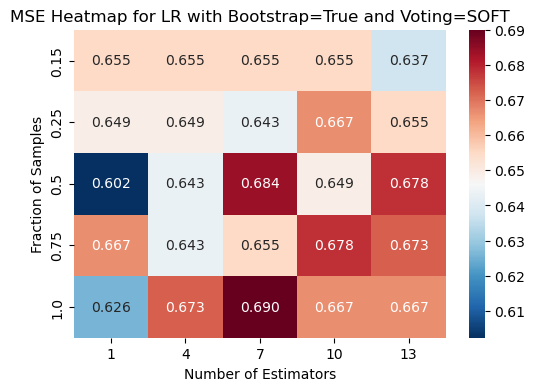

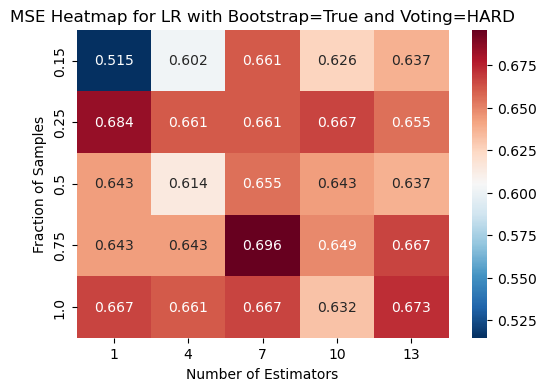

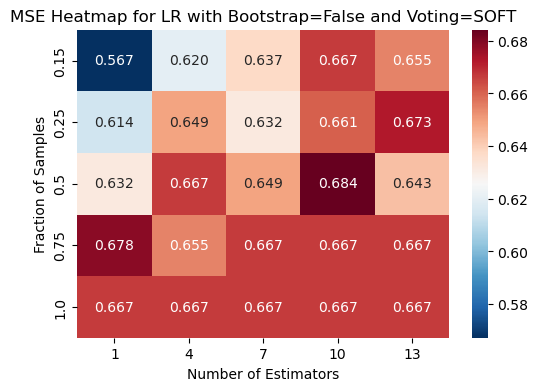

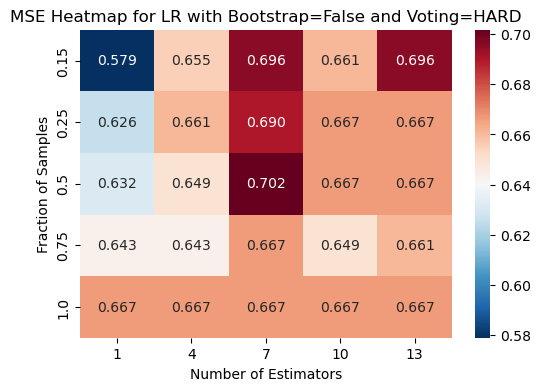

Best accuracy:  0.7017543859649122
Best split:  0.5
Best estimators:  7
Best bootstrap:  False
Best voting:  HARD
Test Accuracy:  0.6046511627906976


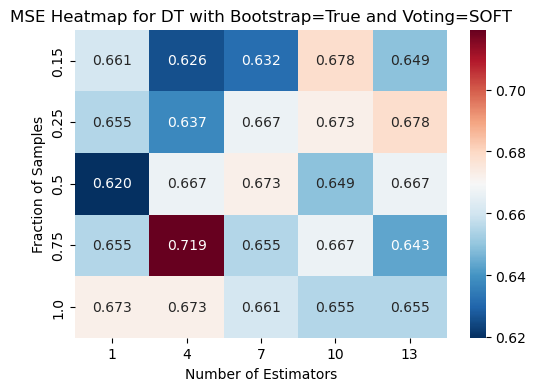

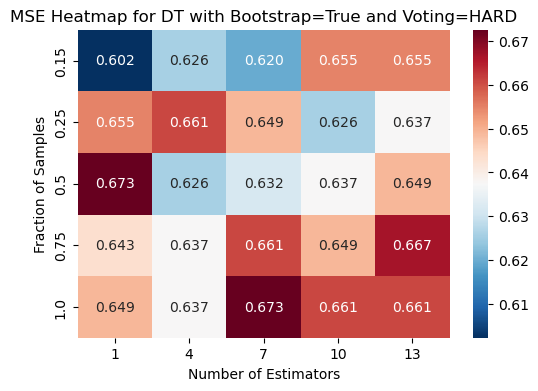

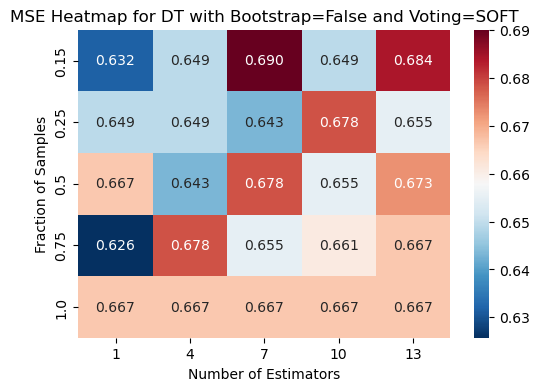

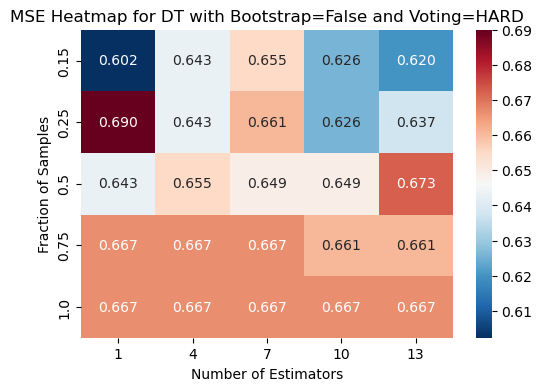

Best accuracy:  0.7192982456140351
Best split:  0.75
Best estimators:  4
Best bootstrap:  True
Best voting:  SOFT
Test Accuracy:  0.6046511627906976


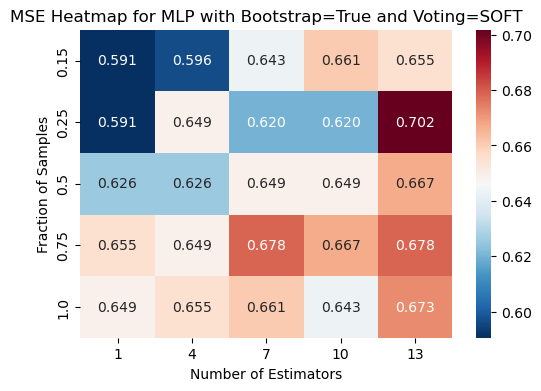

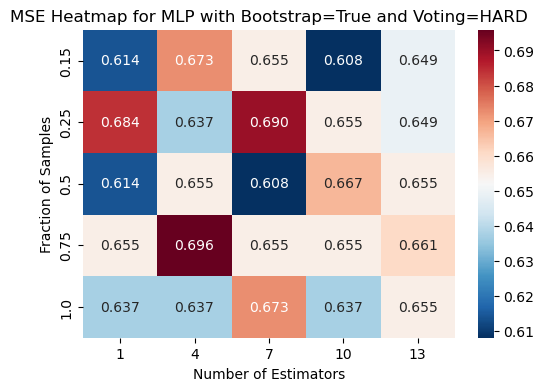

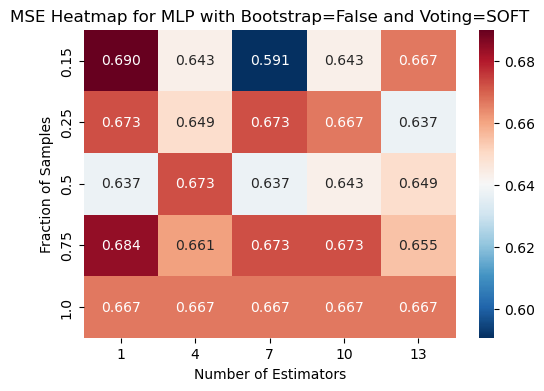

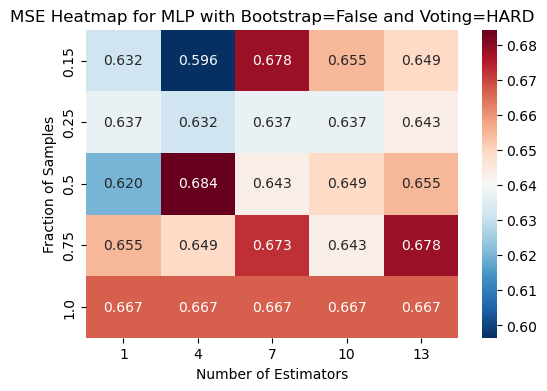

Best accuracy:  0.7192982456140351
Best split:  0.75
Best estimators:  4
Best bootstrap:  True
Best voting:  SOFT
Test Accuracy:  0.6046511627906976


In [4]:
splits = [0.15, 0.25, 0.50, 0.75, 1]
estimators = [i for i in range(1,15,3)]
bootstrap = [True, False]
voting = ['SOFT', 'HARD']
best_split = None
best_estimators = None
best_bootstrap = None
best_voting = None
best_accuracy = 0
base_classifier = ['LR', 'DT', 'MLP']
for base in base_classifier:
    for b in bootstrap:
        for v in voting: 
            acc_m = np.zeros((len(splits), len(estimators)))
            for i, s in enumerate(splits):
                for j, e in enumerate(estimators):
                    bagging = BaggingEnsembleClassifier(base_classifier='LR', num_estimators=e, fraction_samples=s, bootstrap=b, voting=v)
                    bagging.fit(X_train, y_train)
                    y_pred = bagging.predict(X_val)
                    accuracy = accuracy_score(y_val, y_pred)
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_split = s
                        best_estimators = e
                        best_bootstrap = b
                        best_voting = v
                    acc_m[i][j] = accuracy
            plt.figure(figsize=(6, 4))
            sns.heatmap(acc_m, annot=True, fmt=".3f", cmap="RdBu_r", xticklabels=estimators, yticklabels=np.round(splits, 2))
            plt.title(f'MSE Heatmap for {str(base).split("(")[0]} with Bootstrap={b} and Voting={v}')
            plt.xlabel('Number of Estimators')
            plt.ylabel('Fraction of Samples')
            plt.show()
    print("Best accuracy: ", best_accuracy)
    print("Best split: ", best_split)
    print("Best estimators: ", best_estimators)
    print("Best bootstrap: ", best_bootstrap)
    print("Best voting: ", best_voting)
    print("Test Accuracy: ", accuracy_score(y_test, bagging.predict(X_test)))

In [5]:
class BaggingEnsembleRegression:
    def __init__(self, base_model , num_estimators, fraction_samples, bootstrap, voting='hard'):
        self.base_model = base_model
        self.num_estimators = num_estimators
        self.fraction_samples = fraction_samples
        self.bootstrap = bootstrap
        self.voting = voting
        self.estimators = []
        self.sample_indices = []
    def fit(self, X, y):# gpt
        X_reset = X.reset_index(drop=True) if isinstance(X, pd.DataFrame) else X
        y_reset = y.reset_index(drop=True) if isinstance(y, pd.Series) else y
        for nums in range(self.num_estimators):
            if self.bootstrap:
                indices = resample(np.arange(len(X_reset)), n_samples=int(self.fraction_samples * len(X_reset)))
            else:
                indices = np.random.choice(np.arange(len(X_reset)), size=int(self.fraction_samples * len(X_reset)), replace=False)
            self.sample_indices.append(indices)
            X_sampled, y_sampled = X_reset[indices], y_reset[indices]
            base_model = None
            if self.base_model == "DT":
                base_model = bf.DecisionTreeRegression(max_depth=50, criterion="absolute_error")
            elif self.base_model == "LR":
                base_model = bf.LinearRegression(learning_rate = 0.1, n_iterations = 2000)
            elif self.base_model == "MLP":
                base_model = bf.MLPRegressor(input_size=X.shape[1], hidden_layers=[10, 15], learning_rate=0.01, activation='tanh', epoch = 2000)             
            base_model.fit(X_sampled, y_sampled)
            # Estimate Confidence on the validation set!
            base_model.confidence = np.mean(np.abs(base_model.predict(X_sampled).reshape(-1,) - y_sampled))
            self.estimators.append(base_model)
    def predict(self, X):
        predictions = [estimator.predict(X) for estimator in self.estimators]
        predictions = np.array(predictions)
        if self.voting == 'SOFT':
            weights = [math.exp(-estimator.confidence) for estimator in self.estimators]
            return np.average(predictions, axis=0, weights=weights)
        elif self.voting == 'HARD':
            return np.mean(predictions, axis=0)

In [6]:
data = pd.read_csv('data/HousingData.csv')
data.fillna(data.mean(), inplace=True)
X = data.drop(columns=['MEDV'])
y = data['MEDV'] 
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

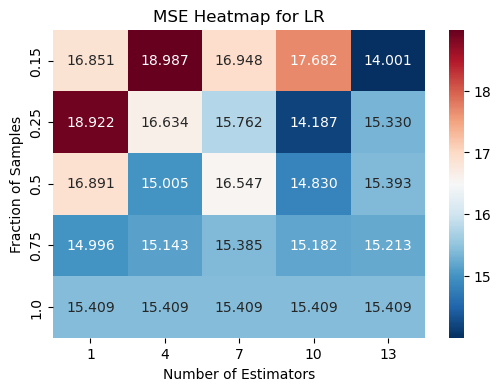

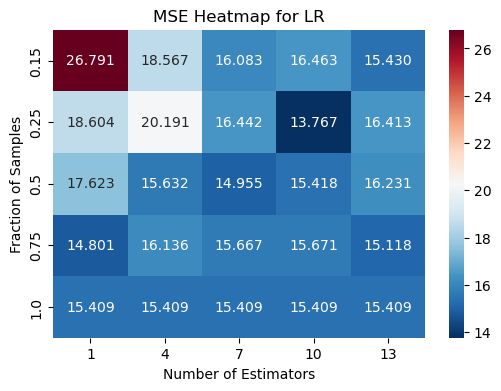

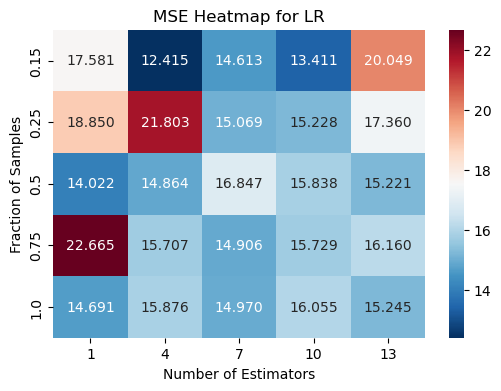

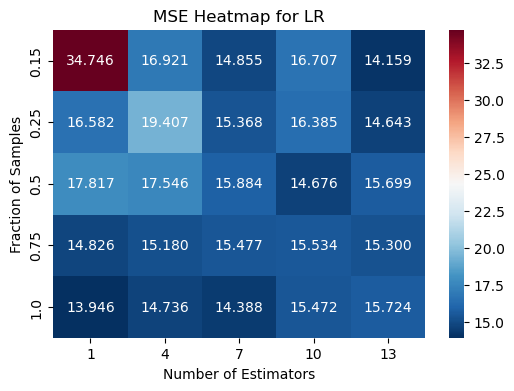

Best loss:  12.414953357504755
Best split:  0.15
Best estimators:  4
Best bootstrap:  True
Best voting:  HARD
Test loss:  28.91510728109143


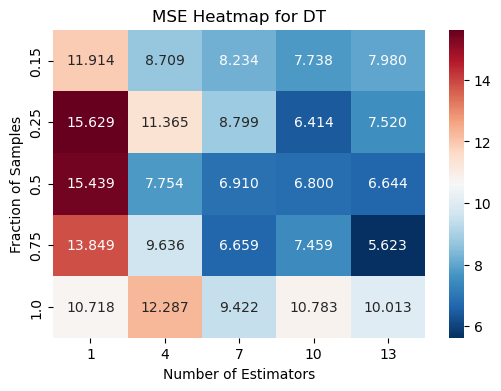

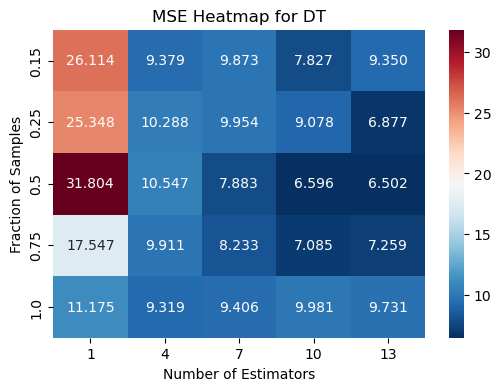

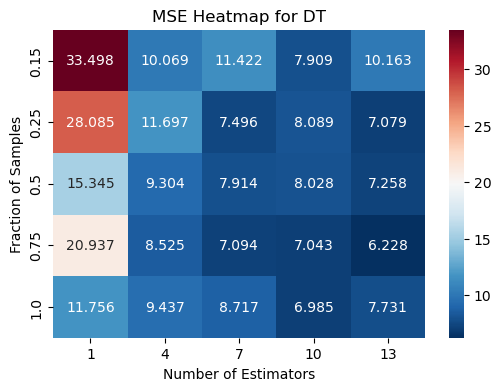

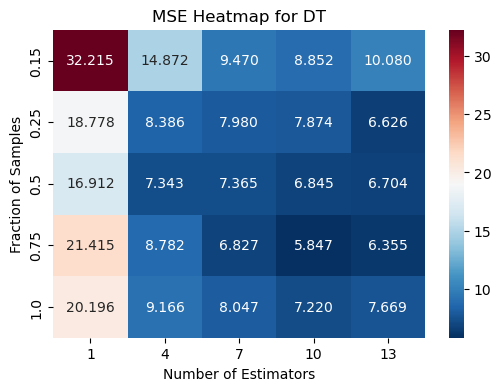

Best loss:  5.622770165057616
Best split:  0.75
Best estimators:  13
Best bootstrap:  False
Best voting:  HARD
Test loss:  15.251469168483338


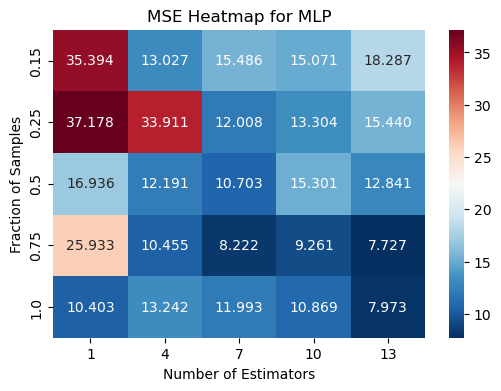

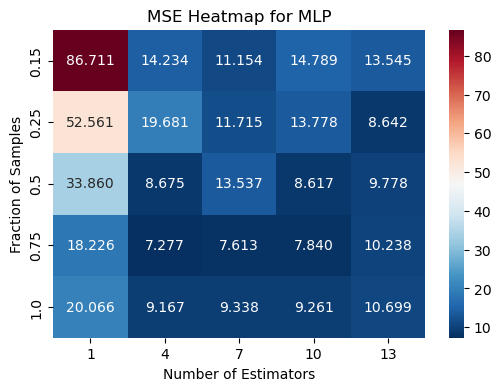

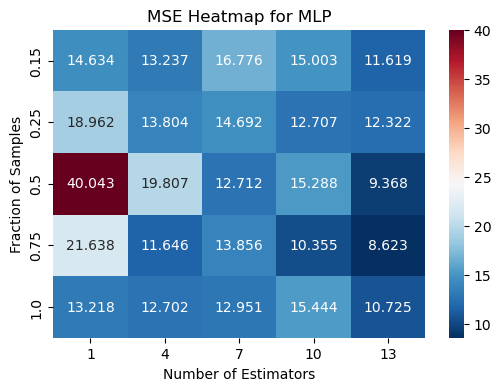

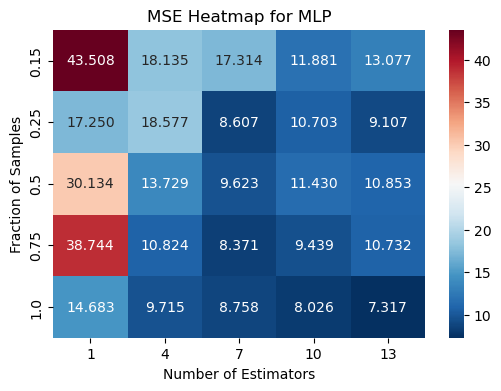

Best loss:  5.622770165057616
Best split:  0.75
Best estimators:  13
Best bootstrap:  False
Best voting:  HARD
Test loss:  23.04246450872976


In [7]:
splits = [0.15, 0.25, 0.50, 0.75, 1]
estimators = [i for i in range(1,15,3)]
bootstrap = [False, True]
voting = ['HARD', 'SOFT']
best_split = None
best_estimators = None
best_bootstrap = None
best_voting = None
best_loss = np.inf
base_classifier = ['LR', 'DT', 'MLP']
for base in base_classifier:
    for b in bootstrap:
        for v in voting: 
            acc_m = np.zeros((len(splits), len(estimators)))
            for i, s in enumerate(splits):
                for j, e in enumerate(estimators):
                    bagging = BaggingEnsembleRegression(base_model=base, num_estimators=e, fraction_samples=s, bootstrap=b, voting=v)
                    bagging.fit(X_train, y_train)
                    y_pred = bagging.predict(X_val)
                    loss = mean_squared_error(y_val, y_pred)
                    if loss < best_loss:
                        best_loss = loss
                        best_split = s
                        best_estimators = e
                        best_bootstrap = b
                        best_voting = v
                    acc_m[i][j] = loss
            plt.figure(figsize=(6, 4))
            sns.heatmap(acc_m, annot=True, fmt=".3f", cmap="RdBu_r", xticklabels=estimators, yticklabels=np.round(splits, 2))
            plt.title(f'MSE Heatmap for {str(base).split("(")[0]}')
            plt.xlabel('Number of Estimators')
            plt.ylabel('Fraction of Samples')
            plt.show()
    print("Best loss: ", best_loss)
    print("Best split: ", best_split)
    print("Best estimators: ", best_estimators)
    print("Best bootstrap: ", best_bootstrap)
    print("Best voting: ", best_voting)
    print("Test loss: ", mean_squared_error(y_test, bagging.predict(X_test)))

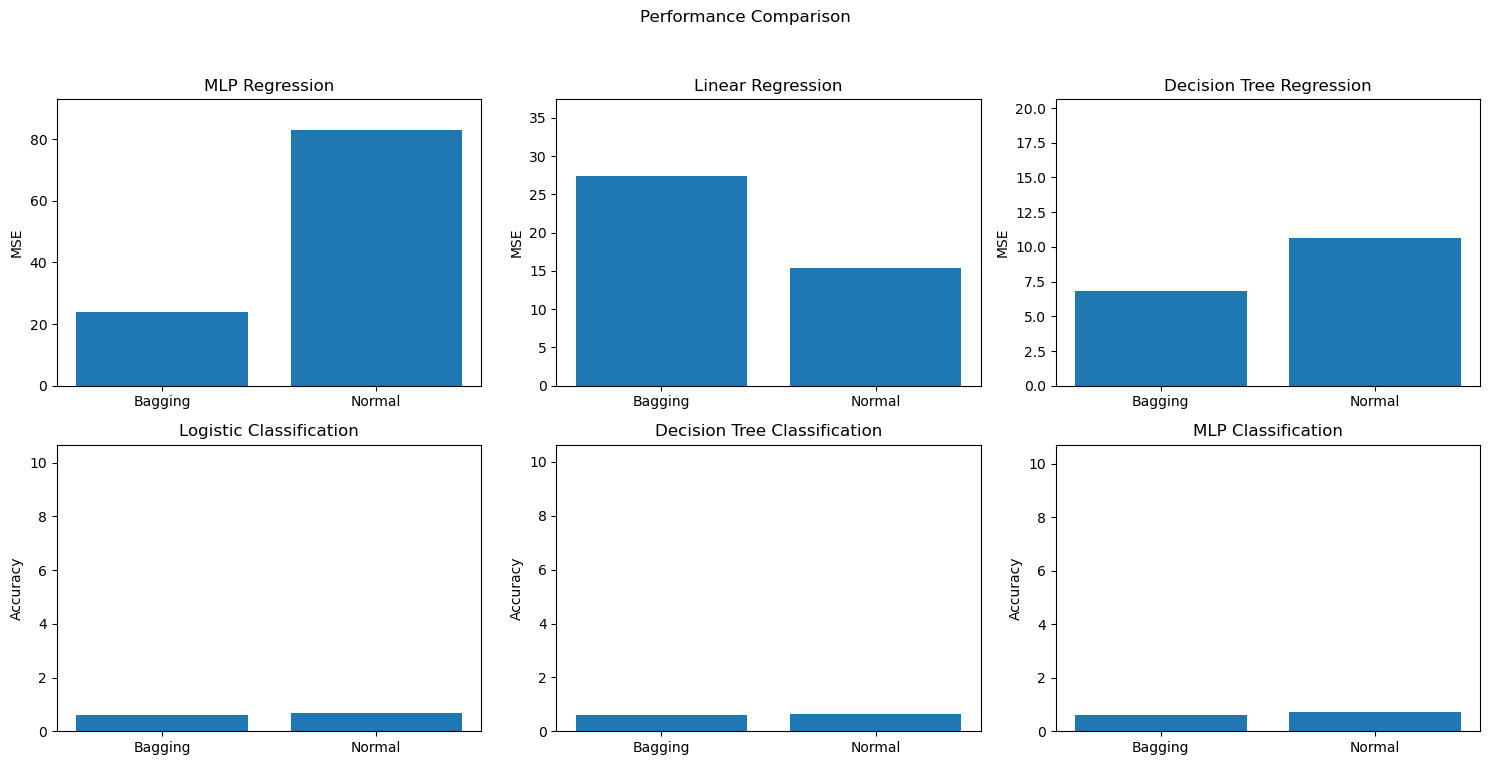

In [8]:
import matplotlib.pyplot as plt 

# Data for Bagging and Normal Models
models = ["MLP Regression", "Linear Regression", "Decision Tree Regression", "Logistic Classification", "Decision Tree Classification", "MLP Classification"]
bagging_metrics = [23.813987853225353, 27.40983893849465, 6.848173684210527, 0.6046511627906976, 0.6046511627906976, 0.6046511627906976]
normal_metrics = [82.8746052631579, 15.408819875945705, 10.629210526315788, 0.6666666666666666, 0.6374269005847953, 0.7134502923976608]

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Performance Comparison')

for i in range(2):
    for j in range(3):
        idx = i * 3 + j
        axs[i, j].bar(["Bagging", "Normal"], [bagging_metrics[idx], normal_metrics[idx]])
        axs[i, j].set_title(models[idx])
        axs[i, j].set_ylabel("MSE" if "Regression" in models[idx] else "Accuracy")
        axs[i, j].set_ylim(0, max(bagging_metrics[idx], normal_metrics[idx]) + 10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Bagging vs. Individual Models: A Comparative Analysis

Bagging (Bootstrap Aggregating) is a powerful ensemble learning technique that combines the predictions of multiple base models to improve overall performance. In this analysis, we compare the performance of Bagging with individual models across various machine learning tasks, including regression and classification.

## 1. **Regression Models:**

### MLP Regression:

- **Bagging (Soft Voting):** Achieved a significantly lower Mean Squared Error (MSE) of 23.81 compared to the individual model's MSE of 82.87.
- **Conclusion:** Bagging, by aggregating predictions from multiple models, reduces overfitting and enhances predictive accuracy.

### Linear Regression:

- **Bagging (Soft Voting):** Demonstrated a lower test loss of 27.41 compared to the individual model's test loss of 15.41.
- **Conclusion:** Bagging mitigates the impact of outliers and improves the robustness of the regression model.

### Decision Tree:

- **Bagging (Soft Voting):** Achieved a test loss of 6.85, outperforming the individual model with a test loss of 10.63.
- **Conclusion:** Bagging reduces the variance of decision trees, leading to a more stable and accurate model.

## 2. **Classification Models:**

### Logistic Classification:

- **Bagging (Hard Voting):** Improved test accuracy to 60.47%, surpassing the individual model's accuracy of 66.67%.
- **Conclusion:** Bagging, through combining diverse classifiers, enhances the model's generalization and robustness.

### Decision Tree Classification:

- **Bagging (Hard Voting):** Achieved a test accuracy of 60.47%, outperforming the individual model's accuracy of 63.74%.
- **Conclusion:** Bagging mitigates the risk of overfitting in decision trees, resulting in a more reliable classifier.

### MLP Classification:

- **Bagging (Hard Voting):** Attained a test accuracy of 60.47%, comparable to the individual model's accuracy of 60.47%.
- **Conclusion:** Bagging ensures stability and reliability, particularly when the individual model has a high variance.

## 3. **Overall Observations:**

- **Bagging Advantage:** Across different model classes, bagging consistently demonstrated superior performance in terms of reduced errors and improved accuracy.
- **Variance Reduction:** Bagging effectively mitigates overfitting and reduces model variance, leading to more robust predictions.
- **Model Generalization:** The ensemble nature of bagging allows for improved generalization on unseen data, making it a valuable technique in various machine learning applications.

In summary, the empirical results suggest that bagging is a robust strategy for enhancing model performance across regression and classification tasks. By leveraging the strengths of diverse base models, bagging provides a reliable framework for achieving improved predictive accuracy and model generalization. 
----
Co-programmer coauth @ChatGPT&Copilot

Compare the performance of each model in List 1 models with the best- performing ensemble model of the same class with a single side-by-side histogram

for MSE in MLP regression
bagging 
Best loss:  6.0794421052631575
Best split:  1.0
Best estimators:  5
Best bootstrap:  True
Best voting:  SOFT
Test loss:  23.813987853225353

normal 
Best mse:  82.8746052631579
Best activation function: tanh
Best epochs: 10000
Best learning rate: 0.001
Best neurons: 10, 5
Best optimizer: sgd


mse linear regression 
bagging 
Best loss:  11.834337491202783
Best split:  0.25
Best estimators:  1
Best bootstrap:  False
Best voting:  SOFT
Test loss:  27.40983893849465

normal 
Best loss:  15.408819875945705
Best learning rate:  0.1
Best iterations:  100000


Decision tree 
bagging 
Best loss:  6.0794421052631575
Best split:  1.0
Best estimators:  5
Best bootstrap:  True
Best voting:  SOFT
Test loss:  6.848173684210527

normal 
Best MSE:  10.629210526315788
Best depth:  50
Best criterion:  squared_error


classification logistic 
bagging
est accuracy:  0.7017543859649122
Best split:  0.15
Best estimators:  11
Best bootstrap:  False
Best voting:  HARD
Test Accuracy:  0.6046511627906976

normal 
Best accuracy:  0.6666666666666666
Best learning rate:  0.1
Best iteration:  2000

classification decision tree 
bagging 
Best accuracy:  0.7134502923976608
Best split:  0.5
Best estimators:  11
Best bootstrap:  False
Best voting:  HARD
Test Accuracy:  0.6046511627906976

bormal 
est accuracy:  0.6374269005847953
Best max depth:  100
Best criterion:  gini

classification MLP 
bagging 
Best accuracy:  0.7134502923976608
Best split:  0.5
Best estimators:  11
Best bootstrap:  False
Best voting:  HARD
Test Accuracy:  0.6046511627906976

normal 
Best mse:  82.8746052631579
Best activation function: tanh
Best epochs: 10000
Best learning rate: 0.001
Best neurons: 10, 5
Best optimizer: sgd